# Network Distance with LION map
We will attempt to use networkx library with the lion map to calculate network distance for people walking between two points
- Download the zipfile
- Extract and save the zipfile
- Open the line shapefile
- Extract nodes
- Calculate network distance!

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import pyproj
import os
import sys
import requests
from zipfile import ZipFile as zzip
import fiona
import pprint
from fiona import collection
from scipy.spatial import cKDTree
import numpy as np

sys.path.append(os.path.realpath('..'))

In [2]:
os.getcwd()

'H:\\Work\\GIS_exploration\\code'

In [3]:
print(fiona.__version__)

1.8.6


## Downloading and Extracting the NYC Lion file
- This does not need to be run repeatedly

In [142]:
url = r"https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyclion_19b.zip"
url = r"http://gis.ny.gov/gisdata/fileserver/?DSID=932&file=SimplifiedStreets_gdb.zip"

# download the file contents in binary format
r = requests.get(url)
# open method to open a file on your system and write the contents
with open("../input_data/SimplifiedStreets_gdb.zip", "wb") as file:
    file.write(r.content)

In [143]:
file_name = "../input_data/nyclion_19b.zip"
file_name = "../input_data/SimplifiedStreets_gdb.zip"

In [144]:
# opening the zip file in READ mode 
with zzip(file_name, 'r') as file: 
    # printing all the contents of the zip file 
    file.printdir() 
  
    # extracting all the files 
    #rint('Extracting all the files now...') 
    file.extractall("../input_data/") 
    print('Done!')

File Name                                             Modified             Size
SimplifiedStreetSegmentQrt.gdb/                2019-06-27 15:21:24            0
SimplifiedStreetSegmentQrt.gdb/a00000001.freelist 2019-06-25 11:42:10        12632
SimplifiedStreetSegmentQrt.gdb/a00000001.gdbindexes 2015-06-29 15:21:36          110
SimplifiedStreetSegmentQrt.gdb/a00000001.gdbtable 2019-06-25 11:42:08          778
SimplifiedStreetSegmentQrt.gdb/a00000001.gdbtablx 2019-06-25 11:42:10         5152
SimplifiedStreetSegmentQrt.gdb/a00000001.TablesByName.atx 2019-06-25 11:42:08         4118
SimplifiedStreetSegmentQrt.gdb/a00000001tmp.freelist 2015-09-30 11:02:10         4440
SimplifiedStreetSegmentQrt.gdb/a00000002.gdbtable 2015-06-29 15:21:36         2055
SimplifiedStreetSegmentQrt.gdb/a00000002.gdbtablx 2019-06-25 11:42:24         5152
SimplifiedStreetSegmentQrt.gdb/a00000003.gdbindexes 2015-06-29 15:21:36           42
SimplifiedStreetSegmentQrt.gdb/a00000003.gdbtable 2015-06-30 03:28:30         

Get layers from GDB

In [233]:
gdb_file = r"../input_data/lion/lion.gdb"
#gdb_file = r"../input_data/SimplifiedStreetSegmentQrt.gdb"
layers = fiona.listlayers(gdb_file)

View the layers

In [234]:
for layer in layers:
    print(layer)

node
node_stname
altnames
lion


## Open the Simplified Street segment data

In [147]:
gdb_file = r"../input_data/SimplifiedStreetSegmentQrt.gdb"
simplified_gdf = gpd.read_file(gdb_file, driver='FileGDB', layer='SimplifiedStreetSegmentQrt')

In [148]:
simplified_gdf.crs

{'init': 'epsg:26918'}

In [149]:
simplified_gdf = simplified_gdf.to_crs({'init': 'epsg:4326'})

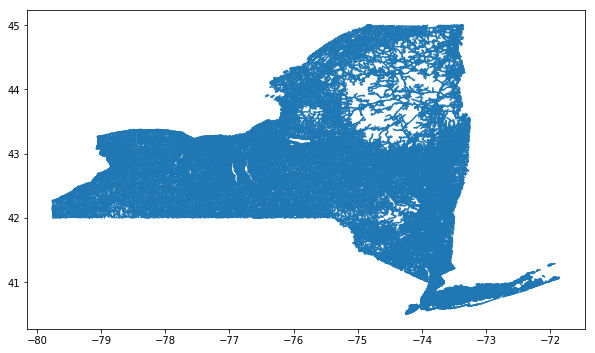

In [150]:
simplified_gdf.plot(figsize = (10,10));

In [157]:
simplified_gdf.columns

Index(['SHIELD', 'HighwayNumber', 'JURISDICTION', 'LeftCountyName',
       'RightCountyName', 'LeftCityTownName', 'RightCityTownName', 'Label',
       'Shape_Length', 'geometry'],
      dtype='object')

In [151]:
simplified_gdf.head()

,SHIELD,HighwayNumber,JURISDICTION,LeftCountyName,RightCountyName,LeftCityTownName,RightCityTownName,Label,Shape_Length,geometry
0,None,None,01,None,None,None,None,,2526.795781,(LINESTRING (-76.54338397779287 41.99877896930...
1,None,None,01,Albany,Albany,Albany,Albany,,44678.323223,(LINESTRING (-73.77578106337552 42.63167605523...
2,None,None,01,Albany,Albany,Bethlehem,Bethlehem,,304.606461,(LINESTRING (-73.85700575010203 42.63751610512...
3,None,None,01,Albany,Albany,Colonie,Colonie,,36.183519,(LINESTRING (-73.72482715149711 42.67663558751...
4,None,None,01,Albany,Albany,Colonie,Colonie,,30105.370691,(LINESTRING (-73.76919450946572 42.67830128602...


In [159]:
simplified_gdf['todrop'] = simplified_gdf['LeftCountyName'].isin(['Bronx','Staten Island','Queens','Manhattan','Brooklyn'])

In [160]:
simplified_gdf['todrop'].value_counts()

False    229027
True       4210
Name: todrop, dtype: int64

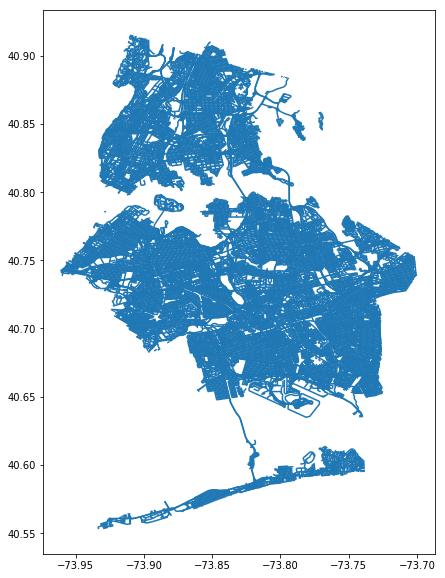

In [164]:
simplified_gdf[simplified_gdf['todrop'] == True].plot(figsize = (10,10))

## Open the lion layer
It was impossible to read in this layer with the old version of `Fiona`. Please ensure that your `Fiona` version is the most up to date.

In [11]:
gdb_file = r"../input_data/lion/lion.gdb"
lion_gdf = gpd.read_file(gdb_file, driver='FileGDB', layer='lion')

In [12]:
lion_gdf.crs

{'init': 'epsg:2263'}

In [13]:
lion_gdf = lion_gdf.to_crs({'init': 'epsg:4326'})

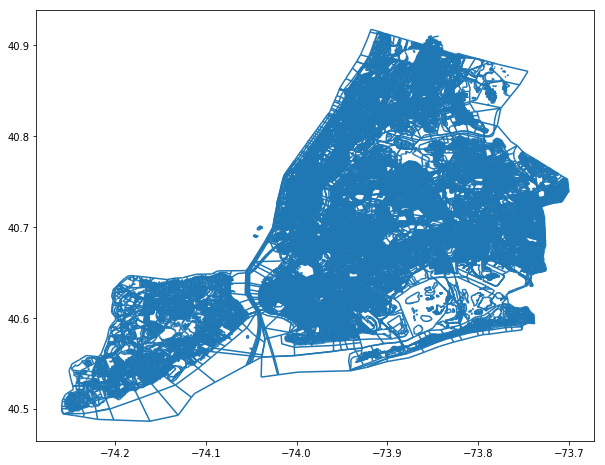

In [14]:
lion_gdf.plot(figsize = (10,10));

In [15]:
lion_gdf.head()

,Street,SAFStreetName,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Length,geometry
0,EAST 168 STREET,,0,U,,B,,T,DOT,,...,699,596,716,599,699,596,716,2251001000000,396.030947,(LINESTRING (-73.90346685871668 40.83035379646...
1,WEST 192 STREET,,0,U,,B,,A,DOT,,...,98,63,99,58,98,63,99,2798401000000,279.360514,(LINESTRING (-73.9012006771837 40.866613078249...
2,UNION AVENUE,,0,U,,B,,W,DOT,,...,1079,1016,1084,1017,1079,1016,1084,2728001000000,618.327133,(LINESTRING (-73.90117669122948 40.82438890917...
3,UNION AVENUE,BEHAGEN PLAYGROUND,0,U,,B,,W,DOT,N,...,None,None,None,0,0,0,0,21279501000000N,618.327133,(LINESTRING (-73.90117669122948 40.82438890917...
4,DELAFIELD AVENUE,,6,U,,B,,T,DOT,,...,4645,4600,4664,4601,4645,4600,4664,2187601000000,670.281037,(LINESTRING (-73.90695663477764 40.89360793519...


We need to clean the `lion_gdf` a little so that non-pedestrians accessible routes are not included.

`FeatureTyp <> 'F' AND FeatureTyp <> '9' AND FeatureTyp <> '1' AND FeatureTyp <> '7' AND FeatureTyp <> '3' AND TrafDir <> '' AND NonPed <> 'V'`

Source: https://pointsunknown.nyc/tutorials/04_Q3_SpatialAnalysis.html

In [68]:
lion_gdf['Street'].count()

226977

In [87]:
lion_gdf['todrop'] = (lion_gdf['NonPed'] == 'V') 

In [88]:
lion_gdf['todrop'].value_counts()

False    201908
True      25069
Name: todrop, dtype: int64

In [89]:
lion_gdf['todrop'] = lion_gdf['FeatureTyp'].isin(['F','9','1','7','3'])

In [90]:
lion_gdf['todrop'].value_counts()

False    202573
True      24404
Name: todrop, dtype: int64

In [94]:
lion_gdf['TrafDir'].value_counts()

T    96024
W    44976
A    40322
     34499
P    11156
Name: TrafDir, dtype: int64

In [98]:
lion_gdf['todrop'] = lion_gdf['TrafDir'].isin([' '])

In [99]:
lion_gdf['todrop'].value_counts()

False    192478
True      34499
Name: todrop, dtype: int64

In [105]:
lion_gdf['todrop'] = (lion_gdf['NonPed'] == 'V') | (lion_gdf['FeatureTyp'].isin(['F','9','1','7','3'])) | (lion_gdf['TrafDir'].isin([' ']))

In [106]:
lion_gdf['todrop'].value_counts()

False    166475
True      60502
Name: todrop, dtype: int64

In [107]:
clean_lion_gdf = gpd.GeoDataFrame(lion_gdf.loc[lion_gdf['todrop'] == False])

Checking that some of the observations were dropped

In [110]:
(clean_lion_gdf['NonPed'] == 'V').value_counts()

False    166475
Name: NonPed, dtype: int64

In [111]:
clean_lion_gdf['FeatureTyp'].isin(['F','9','1','7','3']).value_counts()

False    166475
Name: FeatureTyp, dtype: int64

In [112]:
clean_lion_gdf['TrafDir'].isin([' ']).value_counts()

False    166475
Name: TrafDir, dtype: int64

In [117]:
clean_lion_gdf.drop(['todrop'], axis = 1, inplace = True)

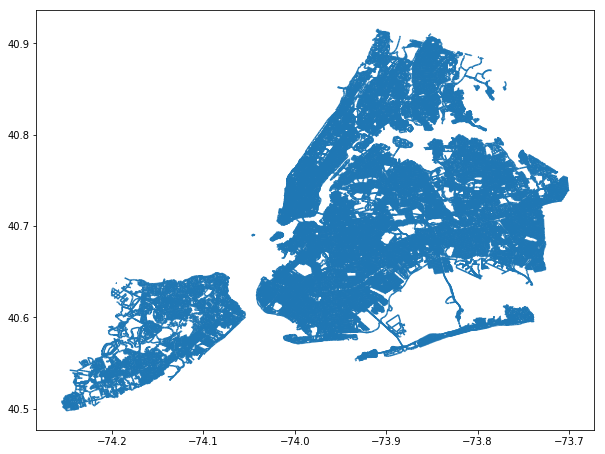

In [113]:
clean_lion_gdf.plot(figsize=(10,10))

### Save the lion layer as a shapefile

In [118]:
fp = r"../intermediate_data/clean_lion_line.shp"
clean_lion_gdf.to_file(fp)

## Test case
We will use two points that are across from each other, but has a highway between them. The network analysis route should move along the road until it find a road that can cross under the highway.

To see the points:

Destination point: https://www.google.com/maps/place/40%C2%B044'13.9%22N+73%C2%B051'50.6%22W/@40.737199,-73.8662467,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d40.737199!4d-73.864058

Origin point: 
https://www.google.com/maps/place/40%C2%B043'56.9%22N+73%C2%B051'42.0%22W/@40.732484,-73.8638547,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d40.732484!4d-73.861666

In [119]:
target_xy = (40.737199,-73.864058)
orig_xy = (40.732484,-73.861666)

In [120]:
fp = r"../intermediate_data/clean_lion_line.shp"
lion_graph = nx.read_shp(fp)

In [121]:
lion_graph

In [220]:
undirected_lion_graph = lion_graph.to_undirected()

In [235]:
undirected_lion_graph

Writing the Graph to shapefile creates the nodes and edges

In [123]:
fp = r"../intermediate_data"
nx.write_shp(lion_graph, fp)

Read the `edges` shapefile as graph and the `node` as geopandas dataframes

In [191]:
fp = r"../intermediate_data/edges.shp"
edges_graph = nx.read_shp(fp, simplify = False, geom_attrs = True)

In [205]:
undirected_edges_graph = edges_graph.to_undirected()

In [124]:
fp = r"../intermediate_data/nodes.shp"
node_gdf = gpd.read_file(fp)

In [192]:
node_gdf.head()

,FID,geometry
0,0,POINT (-73.90346685871668 40.83035379646685)
1,1,POINT (-73.9023800533195 40.82964662740077)
2,2,POINT (-73.9012006771837 40.86661307824997)
3,3,POINT (-73.90207336386543 40.86699910556131)
4,4,POINT (-73.90117669122948 40.82438890917424)


In [125]:
node_gdf.crs = {'init': 'epsg:4326'}

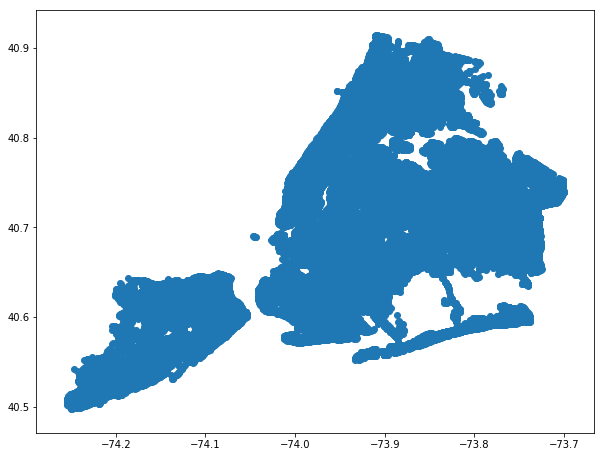

In [126]:
node_gdf.plot(figsize=(10,10));

In [127]:
node_gdf.head()

,FID,geometry
0,0,POINT (-73.90346685871668 40.83035379646685)
1,1,POINT (-73.9023800533195 40.82964662740077)
2,2,POINT (-73.9012006771837 40.86661307824997)
3,3,POINT (-73.90207336386543 40.86699910556131)
4,4,POINT (-73.90117669122948 40.82438890917424)


In [193]:
#target_xy = (40.737199,-73.864058)
#orig_xy = (40.732484,-73.861666)

target_xy = (-73.864058, 40.737199)
orig_xy = (-73.861666,40.732484)

In [194]:
nB = np.array(list(zip(node_gdf.geometry.x, node_gdf.geometry.y)) )
btree = cKDTree(nB)

In [195]:
dist, target_node = btree.query(target_xy,k=1)
print(dist, target_node)

3.7438436323677245e-05 66053


In [196]:
node_gdf['geometry'].loc[node_gdf['FID'] == 66053]

66053    POINT (-73.86404739259665 40.73716309568955)
Name: geometry, dtype: object

In [197]:
dist, orig_node = btree.query(orig_xy,k=1)
print(dist, orig_node)

2.6730270855641812e-05 76256


In [198]:
node_gdf['geometry'].loc[node_gdf['FID'] == 76256]

76256    POINT (-73.86164235281636 40.73247153733231)
Name: geometry, dtype: object

In [208]:
#edges_graph = nx.convert_node_labels_to_integers(edges_graph, first_label = 0)
undirected_edges_graph = nx.convert_node_labels_to_integers(undirected_edges_graph, first_label = 0)

In [221]:
undirected_lion_graph = nx.convert_node_labels_to_integers(undirected_lion_graph, first_label = 0)

In [201]:
#target node
edges_graph.has_node((-73.86404739259665, 40.73716309568955))

True

In [202]:
#origin node
edges_graph.has_node((-73.86164235281636, 40.73247153733231))

True

In [236]:
list(undirected_edges_graph.nodes(data=True))

[(0, {}),
 (1, {}),
 (2, {}),
 (3, {}),
 (4, {}),
 (5, {}),
 (6, {}),
 (7, {}),
 (8, {}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {}),
 (13, {}),
 (14, {}),
 (15, {}),
 (16, {}),
 (17, {}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {}),
 (22, {}),
 (23, {}),
 (24, {}),
 (25, {}),
 (26, {}),
 (27, {}),
 (28, {}),
 (29, {}),
 (30, {}),
 (31, {}),
 (32, {}),
 (33, {}),
 (34, {}),
 (35, {}),
 (36, {}),
 (37, {}),
 (38, {}),
 (39, {}),
 (40, {}),
 (41, {}),
 (42, {}),
 (43, {}),
 (44, {}),
 (45, {}),
 (46, {}),
 (47, {}),
 (48, {}),
 (49, {}),
 (50, {}),
 (51, {}),
 (52, {}),
 (53, {}),
 (54, {}),
 (55, {}),
 (56, {}),
 (57, {}),
 (58, {}),
 (59, {}),
 (60, {}),
 (61, {}),
 (62, {}),
 (63, {}),
 (64, {}),
 (65, {}),
 (66, {}),
 (67, {}),
 (68, {}),
 (69, {}),
 (70, {}),
 (71, {}),
 (72, {}),
 (73, {}),
 (74, {}),
 (75, {}),
 (76, {}),
 (77, {}),
 (78, {}),
 (79, {}),
 (80, {}),
 (81, {}),
 (82, {}),
 (83, {}),
 (84, {}),
 (85, {}),
 (86, {}),
 (87, {}),
 (88, {}),
 (89, {}),
 (90, {}),
 (91, {})

In [222]:
route = nx.shortest_path(G=undirected_lion_graph, source=orig_node, target=target_node, weight = None)

Capture the route nodes and turn it into a `LineString`

In [223]:
route_nodes = node_gdf.loc[route]

In [224]:
route_line = LineString(list(route_nodes.geometry.values))

Make a geodataframe to store the data

In [225]:
route_geom = gpd.GeoDataFrame(crs=node_gdf.crs)
route_geom['geometry'] = None
route_geom['id'] = None

Add the information into the geodataframe

In [226]:
route_geom.loc[0, 'geometry'] = route_line

In [227]:
route_geom.loc[0, 'id'] = str(list(route_nodes['FID'].values))

Now is the time to convert the data into `epsg 2263`.

In [228]:
route_geom.crs

{'init': 'epsg:4326'}

In [229]:
route_geom = route_geom.to_crs({'init': 'epsg:2263'})

In [230]:
route_geom['length_ft'] = route_geom.length
route_geom['length_miles'] = route_geom['length_ft'] *0.000189394

In [231]:
route_geom.head()

,geometry,id,length_ft,length_miles
0,LINESTRING (1022595.221231206 206165.993610297...,"[76256, 58177, 66289, 76111, 72542, 72541, 813...",2893.217327,0.547958


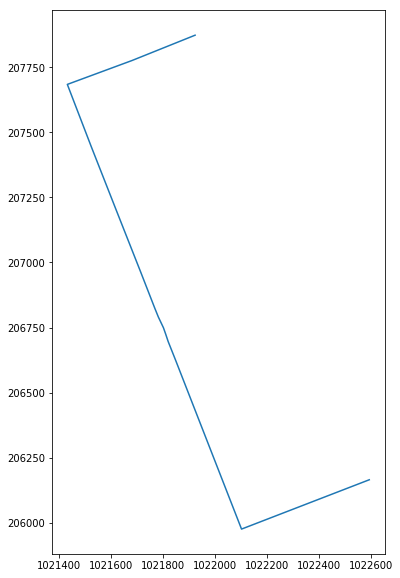

In [232]:
route_geom.plot(figsize = (10,10));

In [237]:
fp =  r"..\intermediate_data\lion_test_route_shapefile.shp"
route_geom[['id','geometry']].to_file(fp)